<a href="https://colab.research.google.com/github/SenhadjiMSaid/Sound-Classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Efficient Deep Learning Approach for Multiclass Sound Classification

> This a semester final mini project of deep learning 2CSI

**Authors**:
- [Senhadji M Said](https://github.com/SenhadjiMSaid)
- [Ali Abbou Oussama](https://github.com/Ali-Abbou-Oussama)
- [DJEZIRI Oussama](https://github.com/DjeziriOus)
- [Baidar Samir](https://github.com/BaidarSamir)


## Installing Dependencies

In [13]:
import os
import numpy as np
import pandas as pd
import torch
import torchaudio # for audio processing
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, TimeMasking, FrequencyMasking
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration setup

These are the key **hyperparameters** for training:

- `sample_rate`: The number of samples per second in an audio clip.
- `n_mels`: Number of mel-frequency bins in spectrograms.
- `batch_size`: Number of samples per batch for training.
- `epochs`: Total training cycles.
- `learning_rate`: Step size for optimizer updates.
- `train_split`: Proportion of data used for training.
- `patience`: How long to wait before early stopping.

In [15]:
CONFIG = {
    "sample_rate": 16000,
    "n_mels": 128,
    "n_fft": 1024,
    "hop_length": 512,
    "batch_size": 32,
    "epochs": 60,
    "learning_rate": 1e-4,
    "audio_duration": 2,
    "num_classes": 10,
    "train_split": 0.8,
    "patience": 10,
    "lr_decay_factor": 0.5,
    "lr_decay_patience": 2,
    "weight_decay": 5e-4,
    "mixup_alpha": 0.4  # Mixup hyperparameter (higher means stronger mixup)
}

## Defining the AudioDataset class

In [26]:
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, train=True):
        self.file_paths = file_paths
        self.labels = labels
        self.train = train

        self.mel_spec_transform = MelSpectrogram(
            sample_rate=CONFIG["sample_rate"],
            n_fft=CONFIG["n_fft"],
            hop_length=CONFIG["hop_length"],
            n_mels=CONFIG["n_mels"]
        )
        self.amp_to_db = AmplitudeToDB(top_db=80)

        # Spectrogram augmentations (SpecAugment)
        self.time_mask = TimeMasking(time_mask_param=20)
        self.freq_mask = FrequencyMasking(freq_mask_param=10)


    def __len__(self): # Added a __len__ method
        return len(self.file_paths)


    def __getitem__(self, idx):
        audio_path = self.file_paths[idx]
        label = self.labels[idx]

        waveform, sr = torchaudio.load(audio_path)
        if sr != CONFIG["sample_rate"]:
            waveform = torchaudio.transforms.Resample(sr, CONFIG["sample_rate"])(waveform)

        # Ensure consistent length
        target_length = int(CONFIG["audio_duration"] * CONFIG["sample_rate"])
        if waveform.size(1) > target_length:
            start = np.random.randint(0, waveform.size(1) - target_length) if self.train else 0
            waveform = waveform[:, start:start + target_length]
        else:
            waveform = F.pad(waveform, (0, target_length - waveform.size(1)))

        # ----- Waveform Augmentations -----
        if self.train:
            waveform = torch.roll(waveform, shifts=np.random.randint(-1600, 1600), dims=1)
            waveform = waveform * np.random.uniform(0.8, 1.2)
        # -----------------------------------

        mel_spec = self.mel_spec_transform(waveform)
        mel_spec = self.amp_to_db(mel_spec)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)  # Normalize

        if self.train:
            mel_spec = self.time_mask(mel_spec)
            mel_spec = self.freq_mask(mel_spec)

        return mel_spec, label


**Mixup** is a data augmentation technique where two training samples are mixed together using a random weight $λ$.

- It helps improve model generalization.
- It prevents the model from becoming overconfident.
- Instead of training on a single label, the model learns a weighted combination of labels.

In [17]:
# Mixup augmentation
def mixup_data(x, y, alpha=CONFIG["mixup_alpha"]):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Function to display a spectrogram

In [18]:
def plot_spectrogram(file_path):
    waveform, sr = torchaudio.load(file_path)
    mel_spec_transform = MelSpectrogram(
        sample_rate=CONFIG["sample_rate"],
        n_fft=CONFIG["n_fft"],
        hop_length=CONFIG["hop_length"],
        n_mels=CONFIG["n_mels"]
    )
    mel_spec = mel_spec_transform(waveform)
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.log2()[0].numpy(), cmap="inferno", aspect="auto")
    plt.title("Mel Spectrogram")
    plt.show()

## Defining the model architecture

In [19]:
class EfficientResNetAudio(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(EfficientResNetAudio, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

## Defining how the training epoch should be like

In [20]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for data, target in tqdm(train_loader, desc="Training"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Apply Mixup augmentation
        mixed_data, targets_a, targets_b, lam = mixup_data(data, target, CONFIG["mixup_alpha"])
        output = model(mixed_data)

        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(output.argmax(dim=1).cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    return total_loss / len(train_loader), f1_score(all_labels, all_preds, average='macro')

## Model training

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
data_dir = "/content/drive/MyDrive/mini-projet-DL/train"

In [23]:
file_paths, labels = [], []

for label_idx, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, file_name))
        labels.append(label_idx)

In [27]:
dataset = AudioDataset(file_paths, labels, train=True)
train_size = int(CONFIG["train_split"] * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [28]:
train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [29]:
model = EfficientResNetAudio(num_classes=CONFIG["num_classes"]).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [30]:
for epoch in range(CONFIG["epochs"]):
    train_epoch(model, train_loader, criterion, optimizer, device)

Training:   0%|          | 0/260 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training:   0%|          | 0/260 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warning

In [31]:
torch.save(model.state_dict(), 'best_model.pth')

## Model Evaluation

In [32]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

EfficientResNetAudio(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

In [33]:
def evaluate_model(model, test_loader, device, class_names=None):
    """
    Comprehensive evaluation of the model with detailed metrics and visualizations

    Args:
        model: The trained model to evaluate
        test_loader: DataLoader for test data
        device: Device to use for computation
        class_names: List of class names (optional)
    """
    if class_names is None:
        class_names = [
            "tram", "airport", "park", "metro", "metro_station",
            "park", "public_square", "shopping_mall",
            "street_pedestrian", "street_traffic"
        ]

    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    # Collect predictions
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)

            preds = output.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target.cpu().numpy())

    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    # Print overall metrics
    print(f"Test F1 Score (Macro): {f1:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Generate per-class metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Save metrics to CSV
    report_df.to_csv('classification_report.csv')
    print("Classification report saved to 'classification_report.csv'")

    # Show per-class F1 scores
    plt.figure(figsize=(12, 6))
    class_f1_scores = [report[c]['f1-score'] for c in class_names]
    bars = plt.bar(class_names, class_f1_scores)
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('f1_scores_per_class.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Save all results to a single file
    results = {
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'per_class_metrics': report
    }

    # Save as pickle for later use
    import pickle
    with open('evaluation_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results


Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 65/65 [07:13<00:00,  6.67s/it]


Test F1 Score (Macro): 0.5739
Precision (Macro): 0.5752
Recall (Macro): 0.5771


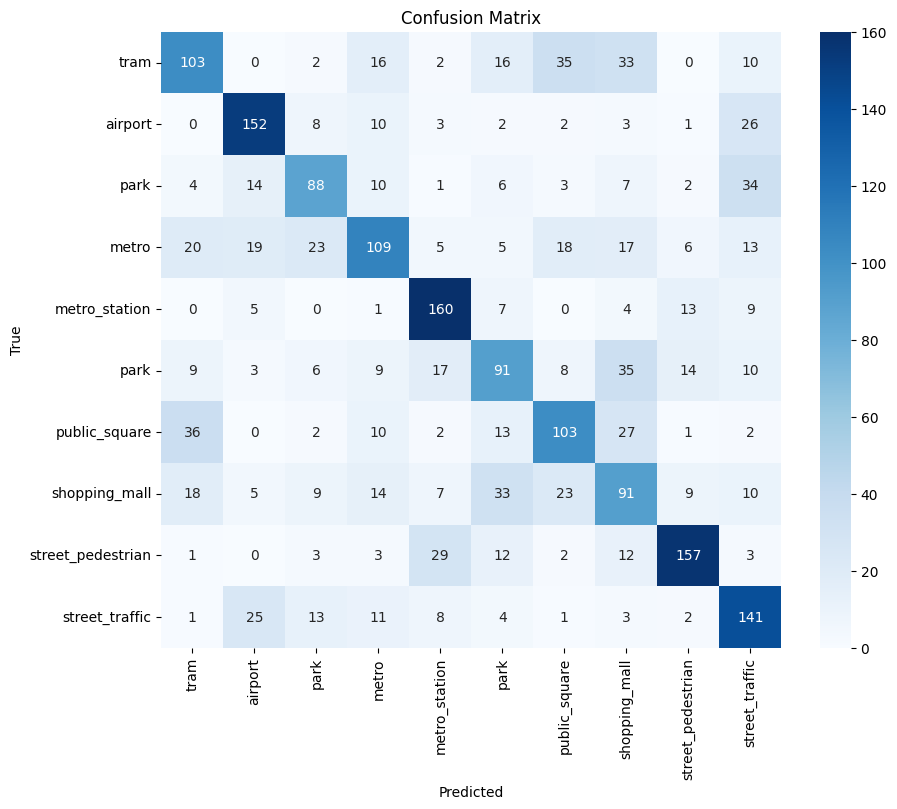

Classification report saved to 'classification_report.csv'


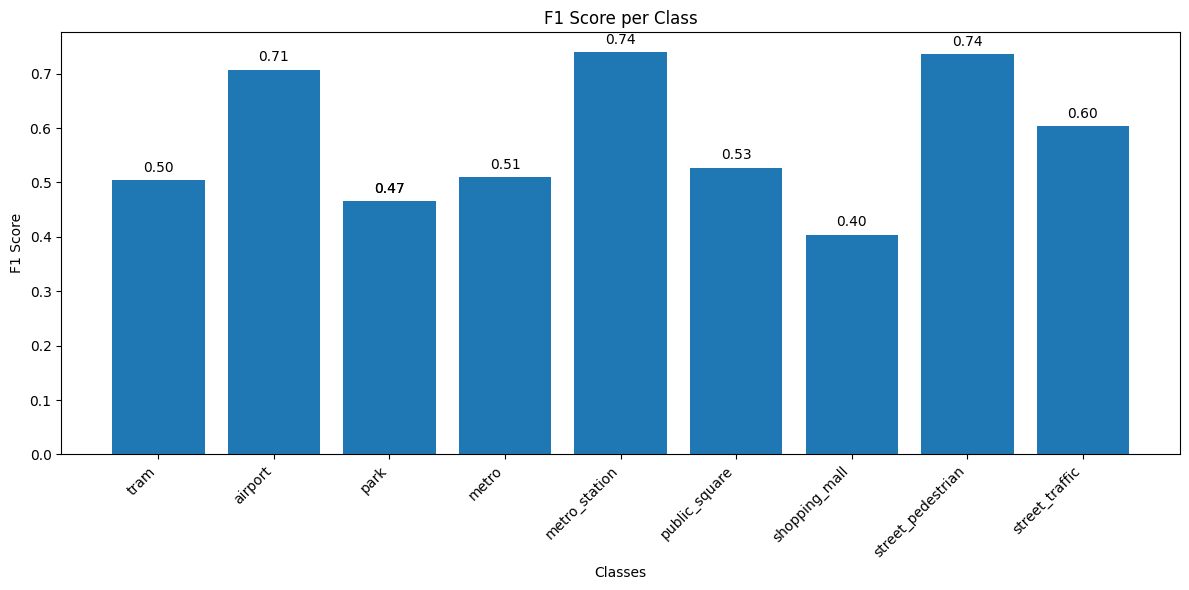

In [34]:
evaluation_results = evaluate_model(model, val_loader, device)